# TP Module 9 : Optimisation des modèles

But de l'optimisation des modèles :

- Réduire la taille du modèle.
- Accélérer le temps d'inférence.
- Réduire la consommation énergétique du modèle.


Quelles sont les différentes façon d'optimiser une modèle ?

- Réduire sa précision numérique.
  - Les paramètres et fonctions d'activations d'un modèle sont le plus souvent représentés en `float32`. **Quantification**
- Toutes les opérations du graphe d'un modèle sont elles nécéssaires durant l'inférence ? **Fusion des couches**
- Tous les paramètres contribuent ils à la performance du modèle ? **Pruning**
- Améliorer les allers-retours entre GPU et CPU.

- Ref
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/A_tale_of_quantization.ipynb#scrollTo=HHZ-SsZU5VAW
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Model_Pruning_in_Deep_Learning_with_tfmot.ipynb#scrollTo=cEDnyetVLTcM
  - https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Custom_Image_Classification_EdgeTPU.ipynb#scrollTo=57GUpImAP7KC

- TF Lite

  - https://www.tensorflow.org/lite/performance/post_training_quantization

  - https://www.tensorflow.org/lite/performance/post_training_quant

  - https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization

  - https://www.tensorflow.org/lite/performance/best_practices#profile_your_application_with_platform_specific_tools

  - https://www.tensorflow.org/lite/performance/post_training_integer_quant

- Model Optimization/Pruning

  - https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras#overview

  - https://www.tensorflow.org/model_optimization/api_docs/python/tfmot

  - https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity

   -https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/PruningSchedule

  - https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide

   -https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide#prune_whole_model_sequential_and_functional

 - https://www.tensorflow.org/model_optimization/guide/quantization/training

 - https://tensorflow.google.cn/model_optimization/guide/pruning/pruning_with_keras

- Save/Load

  - https://www.tensorflow.org/tutorials/keras/save_and_load













## **Import libs**

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(f'tf : {tf.__version__}')
print(f'keras : {keras.__version__}')

import pandas as pd
import numpy as np
import random
import os
import datetime

# freeze de l'aléatoire, pour avoir des expériences reproductibles.
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

tf : 2.1.0
keras : 2.2.4-tf


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import shutil
import time
import cv2

In [ ]:
!nvidia-smi

Tue Sep  1 09:25:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
comp = pd.DataFrame()
comp['model'] = []
comp['précision'] = []

## Import du dataset

In [ ]:
# Gather Flowers-17 dataset
data_root = tf.keras.utils.get_file(
  "/content/flower_photos", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
   untar=True)

In [ ]:
# Untar the dataset
!tar -xvf flower_photos.tar.gz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [ ]:
# All the paths of the flowers
ALL_IMG_PATHS = list(paths.list_images("flower_photos"))
ALL_IMG_PATHS[:5]

['flower_photos/tulips/13510057763_01b832d919.jpg',
 'flower_photos/tulips/486896118_bcc7b8e1d6.jpg',
 'flower_photos/tulips/7247182064_f8d6759446_n.jpg',
 'flower_photos/tulips/14093884601_c87b5cd663_n.jpg',
 'flower_photos/tulips/17224410762_402455ed8f.jpg']

### Visualisation

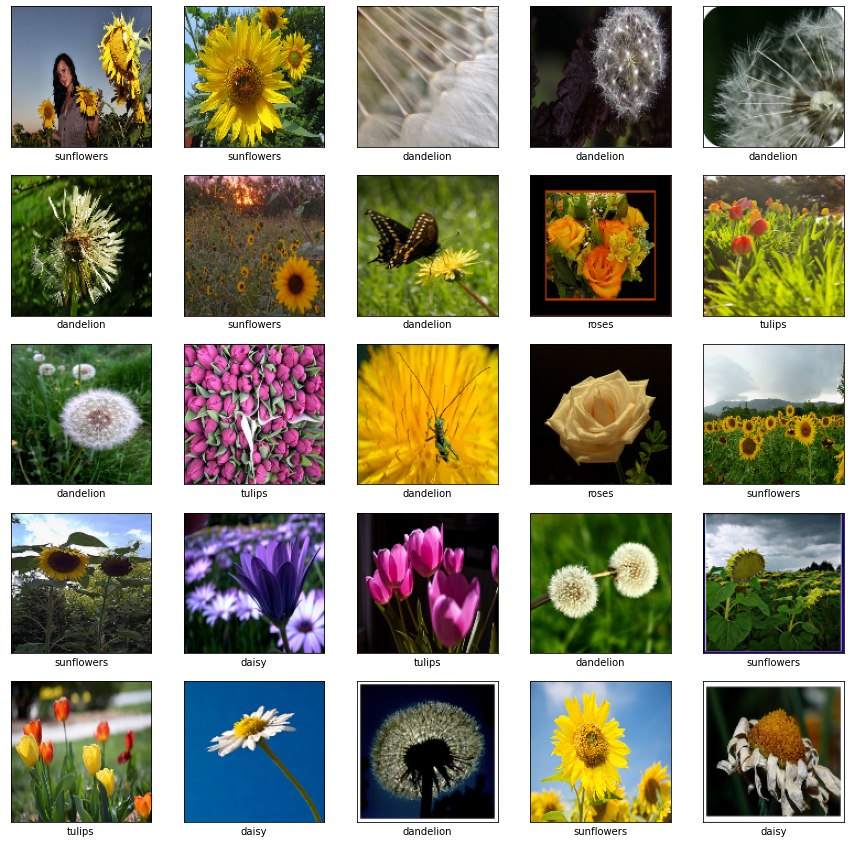

In [ ]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

### Train, val, test datasets

In [ ]:
flower_train, flower_val = train_test_split(ALL_IMG_PATHS, test_size=0.20, random_state=RANDOM_SEED)
flower_test, flower_val = train_test_split(flower_val, test_size=0.5, random_state=RANDOM_SEED)
print(f'images in train : {len(flower_train)}, images in val : {len(flower_val)}, images in test {len(flower_test)}')

images in train : 2936, images in val : 367, images in test 367


In [ ]:
dic = {b'daisy': 0, b'dandelion': 1, b'roses': 2, b'sunflowers': 3, b'tulips': 4}
label_train = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_train]
label_val = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_val]
label_test = [dic[tf.strings.split(filename, '/')[1].numpy()] for filename in flower_test]
print(f'labels in train : {len(label_train)}, labels in val : {len(label_val)}, labels in test {len(label_test)}')

labels in train : 2936, labels in val : 367, labels in test 367


In [ ]:
NUM_CLASSES = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE

def parse_image(filename,label):
  # convert the label to one-hot encoding
  label = tf.one_hot(label, NUM_CLASSES)
  
  #decode image
  image = tf.io.read_file(filename)
  #Don't use tf.image.decode_image, or the output shape will be undefined
  image = tf.image.decode_jpeg(image)
  #This will convert to float values in [0, 1]
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [224, 224])
  return image, label
  
def train_preprocess(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)

  return image, label

def create_train_dataset(features, labels, batch=32, repet=1, prefetch=1):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
  dataset = dataset.repeat(repet)
  dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
  dataset = dataset.map(train_preprocess, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(prefetch)
  return dataset

def create_val_dataset(features, labels, batch=32, repet=1, prefetch=1):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
  dataset = dataset.repeat(repet)
  dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(prefetch)
  return dataset

In [ ]:
ds_train = create_train_dataset(flower_train, label_train)
ds_val = create_val_dataset(flower_val, label_val)
ds_test = create_val_dataset(flower_test, label_test)

## Construction du modèle & entraînement du modèle

### Construction

In [ ]:
# Load the MobileNetV2 model but exclude the classification layers
conv_base = MobileNetV2(weights="imagenet", 
                        include_top=False,
                        input_shape=(224, 224, 3))

In [ ]:
def get_training_model():
    # We are fine-tuning the extractor model
    conv_base.trainable = True
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = conv_base.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=conv_base.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

### Entraînement

In [ ]:
# LR schedule configuration
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [ ]:
# LR schedule
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 1.0002177807148294e-05


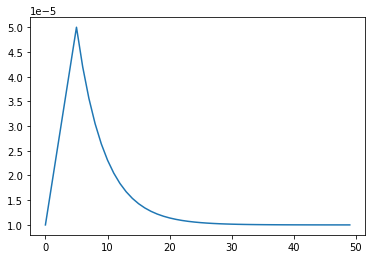

In [ ]:
# How does the LR schedule looks like?
rng = [i for i in range(50)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [ ]:
# Train the model
flower_model = get_training_model()
start = time.time()
history = flower_model.fit(ds_train,
                           validation_data=ds_val,
                           epochs=10,
                           callbacks=[lr_callback])
print("Total training time: ",time.time()-start)

Train for 92 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
92/92 [==============================] - 27s 291ms/step - loss: 1.6304 - accuracy: 0.3348 - val_loss: 1.2459 - val_accuracy: 0.5123

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/10
92/92 [==============================] - 19s 208ms/step - loss: 0.9983 - accuracy: 0.6117 - val_loss: 0.8482 - val_accuracy: 0.6621

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/10
92/92 [==============================] - 19s 210ms/step - loss: 0.6268 - accuracy: 0.7847 - val_loss: 0.5672 - val_accuracy: 0.7820

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/10
92/92 [==============================] - 20s 212ms/step - loss: 0.4487 - accuracy: 0.8341 - val_loss: 0.4797 - val_accuracy: 0.8202

Epoch 00005: LearningRateScheduler reducing learning rate 

#### Evaluation

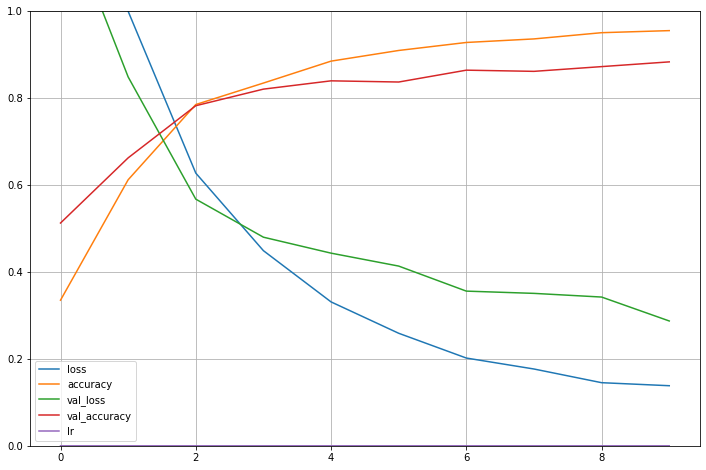

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
_, accuracy = flower_model.evaluate(ds_test)

comp = comp.append({'model': 'unoptim_model', 'précision' : accuracy}, ignore_index=True)
print(comp)

12/12 [==============================] - 1s 69ms/step - loss: 0.3031 - accuracy: 0.8965
           model  précision
0  unoptim_model   0.896458


### Sauvegarde

Pour convertir un modèle, que ce soit avec TF Lite ou avec TensorRT, on doit le sauvegarder sous la format `SavedModel` qui est le format standard de TensorFlow. La méthode classique où l'on utilise le format `.h5` est elle propre à `tf.keras`.

In [ ]:
# Unoptimized (SavedModel format)
flower_model.save("base_model/flower_model_no_op")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: base_model/flower_model_no_op/assets


In [ ]:
# Check size
!du --all -h base_model/flower_model_no_op

4.4M	base_model/flower_model_no_op/saved_model.pb
34M	base_model/flower_model_no_op/variables/variables.data-00000-of-00001
140K	base_model/flower_model_no_op/variables/variables.data-00000-of-00002
44K	base_model/flower_model_no_op/variables/variables.index
34M	base_model/flower_model_no_op/variables/variables.data-00001-of-00002
67M	base_model/flower_model_no_op/variables
4.0K	base_model/flower_model_no_op/assets
71M	base_model/flower_model_no_op


Charger un modèle se fait de la même façon, que l'on utilise le format `SavedModel` ou `.h5`.

In [ ]:
flower_model = tf.keras.models.load_model('base_model/flower_model_no_op')

# Check its architecture
flower_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

## TensorRT

- https://github.com/tensorflow/tensorrt/blob/master/tftrt/examples/image-classification/Colab-TF-TRT-inference-from-Keras-saved-model.ipynb

- https://github.com/tensorflow/tensorrt/blob/master/tftrt/examples/image-classification/TF-TRT-inference-from-saved-model.ipynb

- https://github.com/tensorflow/tensorrt/tree/master/tftrt/examples/image-classification

- https://sayak.dev/tf.keras/tensorrt/tensorflow/2020/07/01/accelerated-inference-trt.html

### Installation TensorRT Converter & Runtime

Actuellement, on a deux versions de Jetpack (le kit de développement de NVidia) disponibles : la 4.3 et la 4.4. 

La version 4.4 fonctionne avec une version Tensorflow 2.2 optimisée pour Jetson Nano, et la 4.3 avec une version de Tensorflow 2.1 optimisée. Chacune de ces deux version a une versio différente de TensorRT :

- Jetpack 4.4 possède la version TensorRT 7.1.3,
- Jetpack 4.3 possède la version TensorRT 6.0.1.

Pour savoir quelle version l'on doit utiliser, il faut vérifier la version de cuDNN utilisée (le driver deep learning de Nvidia).

- Jetpack 4.4 supporte cuDNN 8.0, avec une version minimale de Cuda 10.2,
- Jetpack 4.3 supporte cuDNN 7.6.3, avec une version minimale de Cuda 10.0.

Pour voir les versions utilisées sur Colab (ou sur n'importe quel pc Linux), on lance les commandes suivantes.

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


on est donc donc sous Cuda 10.1 avec cuDNN 7.6.5, e qui fait que l'on doit uiliser la version présente dans Jetpack 4.3.

Pour avoir des versions compatibles de TensorFlow & TensorRT, on va downgrader vers la version $2.1$ de TensorFlow.

In [ ]:
!pip install tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 3.9MB 56.8MB/s 
     |████████████████████████████████| 450kB 36.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=3bc75e9d32a7cb7e7f51cf622fb8940d62e0b24ed504ee3cbe5e28f7cf90b7bc
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [ ]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/libnvinfer6_6.0.1-1+cuda10.1_amd64.deb
dpkg -i libnvinfer6_6.0.1-1+cuda10.1_amd64.deb

Selecting previously unselected package libnvinfer6.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack libnvinfer6_6.0.1-1+cuda10.1_amd64.deb ...
Unpacking libnvinfer6 (6.0.1-1+cuda10.1) ...
Setting up libnvinfer6 (6.0.1-1+cuda10.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...


--2020-09-01 08:47:40--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/libnvinfer6_6.0.1-1+cuda10.1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71245796 (68M) [application/x-deb]
Saving to: ‘libnvinfer6_6.0.1-1+cuda10.1_amd64.deb’

     0K .......... .......... .......... .......... ..........  0% 2.22M 31s
    50K .......... .......... .......... .......... ..........  0% 7.17M 20s
   100K .......... .......... .......... .......... ..........  0% 2.04M 24s
   150K .......... .......... .......... .......... ..........  0% 53.5M 19s
   200K .......... .......... .......... .......... ..........  0% 8.94M 16s
   250K .......... .......... .......... .......... ..........  0% 3.40M 17s
   300K .......... .......... .......... ...

In [ ]:
!apt install libnvinfer-plugin6=6.0.1-1+cuda10.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  libnvinfer-plugin6
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 1,751 kB of archives.
After this operation, 4,508 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  libnvinfer-plugin6 6.0.1-1+cuda10.1 [1,751 kB]
Fetched 1,751 kB in 0s (7,666 kB/s)
Selecting previously unselected package libnvinfer-plugin6.
(Reading database ... 144584 files and directories currently installed.)
Preparing to unpack .../libnvinfer-plugin6_6.0.1-1+cuda10.1_amd64.deb ...
Unpacking libnvinfer-plugin6 (6.0.1-1+cuda10.1) ...
Setting up libnvinfer-plugin6 (6.0.1-1+cuda10.1) ...
Processing triggers for libc-bin (2.27-3ubunt

In [ ]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer-plugin6                     6.0.1-1+cuda10.1                                  amd64        TensorRT plugin libraries
ii  libnvinfer6                            6.0.1-1+cuda10.1                                  amd64        TensorRT runtime libraries


In [ ]:
from tensorflow.compiler.tf2tensorrt.wrap_py_utils import get_linked_tensorrt_version
from tensorflow.compiler.tf2tensorrt.wrap_py_utils import get_loaded_tensorrt_version

print(f"Linked TensorRT version {get_linked_tensorrt_version()}")
print(f"Loaded TensorRT version {get_loaded_tensorrt_version()}")

Linked TensorRT version (6, 0, 1)
Loaded TensorRT version (6, 0, 1)


Les deux versions de Tensorflow et TensorRT installées sont maintenant compatibles. Lançons la conversion.

https://developer.ibm.com/components/ibm-power/tutorials/introducing-tensorflow-with-tensorrt/

https://github.com/tensorflow/tensorrt/tree/master/tftrt/examples/image-classification

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

- TensorFlow TensorRT (TF-TRT) prend en entrée pour optimiser le modèle un modèle entraîné via `tf.keras` sous la forme `SavedModel`, ie un `.pb`.

Définisoons un dataset de validation, comme pour Tensorflow Lite.

In [ ]:
# Prepare validation sets
# Extract the image paths from the train set

# Empty labels for storing images and labels
val_images = []

# Iterate over the image paths
for image in flower_val:
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = plt.imread(image).astype("float32")
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, 0)
    image_pixels = image_pixels / 255.

    # Append to the list
    val_images.append(image_pixels)
    val_labels = label_val

# Create NumPy array
val_images = np.array(val_images)

### TF-TRT FP32 modèle

On aura besoin de renseigner l'adresse `input_saved_model_dir=dir`, où `dir/saved_model.pb` existe. Passons là en variable.

In [ ]:
dir = 'base_model/flower_model_no_op/'

In [ ]:
!saved_model_cli show --all --dir base_model/flower_model_no_op/

2020-09-01 09:36:58.234629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-09-01 09:36:58.379139: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
   

**Conversion parameters**

- There are additional parameters that can be passed to `saved_model_cli` and `TrtGraphConverterV2`:

    - `precision_mode` : The precision mode to use (FP32, FP16, or INT8)
    - `minimum_segment_size` : The minimum number of TensorFlow nodes required for a TensorRT subgraph to be valid.
    - `is_dynamic_op` : TensorRT engines are converted and built at model run time instead of during the `converter.convert()` call. This is required if there are tensors with unknown or dynamic shapes.
    - `use_calibration` : Only used if `precision_mode='INT8'`. If True, a calibration graph will be created, and `converter.calibrate()` should be called. This is the recommended option. If False, all tensors that will not be fused must have quantization nodes. See NVIDIA’s INT8 Quantization for details.
    - `max_batch_size` : Used when `is_dynamic_op=False`. This is the maximum batch size for TensorRT engines. At run time, smaller batch sizes can be used, but a larger batch size will result in an error.
    - `maximum_cached_engines` : Used when `is_dynamic_op=True`. This limits the number of TensorRT engines that are cached, per TRTEngineOp.


In [ ]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32)

converter = trt.TrtGraphConverterV2(input_saved_model_dir=dir,
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='dir_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (6, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (6, 0, 1)
INFO:tensorflow:Could not find TRTEngineOp_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: dir_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


In [ ]:
!saved_model_cli show --all --dir dir_saved_model_TFTRT_FP32

2020-09-01 09:34:25.612510: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-09-01 09:34:25.612670: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-09-01 09:34:25.612690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVAL

On charge le modèle converti est on lance une prédiction.

In [ ]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

from tensorflow.keras.preprocessing import image
from tensorflow.python.saved_model import tag_constants

In [ ]:
def predict_tftrt(input_saved_model, img_path_i):
  """Runs prediction on a single image and shows the result.
  input_saved_model (string): Name of the input model stored in the current dir
  """
  img_path = ALL_IMG_PATHS[img_path_i]
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  x = tf.constant(x)
  
  saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
  signature_keys = list(saved_model_loaded.signatures.keys())
  print(signature_keys)

  infer = saved_model_loaded.signatures['serving_default']
  print(infer.structured_outputs)

  labeling = infer(x)
  preds = labeling['dense_1'].numpy()
  print(f'True: {image_path.split("/")[1]} - Predicted: {CLASSES[np.argmax(preds)]}')
  plt.subplot(2,2,1)
  plt.imshow(img);
  plt.axis('off');
  plt.title('pred')

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((val_images,val_labels))

def evaluate_tftrt_model(input_saved_model):
  acc = tf.keras.metrics.Accuracy()

  # Load TF TRT model
  saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
  signature_keys = list(saved_model_loaded.signatures.keys())  
  infer = saved_model_loaded.signatures['serving_default']
  
  # Run predictions on every image in the "test" dataset.
  predictions = []
  
  for val_image, val_label in dataset:
    # Run inference.

    #print(infer.structured_outputs)

    labeling = infer(val_image)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    preds = labeling['dense_1'].numpy()
    flower_id = np.argmax(preds)
    predictions.append(flower_id)
    
    # Compare prediction results with ground truth labels to calculate accuracy.
  
  acc.update_state(val_labels, predictions)
  acc = acc.result().numpy()

  return accuracy

In [ ]:
def benchmark_saved_model(input_saved_model, BATCH_SIZE=32):
  # Load TF TRT model
  saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
  signature_keys = list(saved_model_loaded.signatures.keys())  
  print(signature_keys)

  infer = saved_model_loaded.signatures['serving_default']
  print(infer.structured_outputs)

  print('Warming up for 50 batches...')
  cnt = 0
  for x, y in dataset:
      labeling = infer(x)
      cnt += 1
      if cnt == 50:
          break

  print('Benchmarking inference engine...')
  num_hits = 0
  num_predict = 0
  start_time = time.time()
  for x, y in dataset:
      labeling = infer(x)
      preds = labeling['dense_1'].numpy()
      num_hits += np.sum(preds == y)
      num_predict += preds.shape[0]
      
  print(f'Accuracy : {100*num_hits/num_predict:.2f%%}')
  print(f'Inference speed: {num_predict/(time.time()-start_time):.2f} samples/s')

In [ ]:
acc = evaluate_tftrt_model('dir_saved_model_TFTRT_FP32')

print(acc)

0.8964578


In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile
  import tempfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print(f"Size of gzipped TF-TRT FP32 model: {get_gzipped_model_size('dir_saved_model_TFTRT_FP32/saved_model.pb')/1e6:.2f} Mb")

Size of gzipped pruned model trained from scratch: 22.02 Mb


['serving_default']
{'dense_1': TensorSpec(shape=<unknown>, dtype=tf.float32, name='dense_1')}
flower_photos/tulips/7094415739_6b29e5215c_m.jpg - Predicted: dandelion


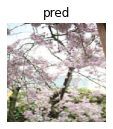

In [ ]:
predict_tftrt('dir_saved_model_TFTRT_FP32')

In [ ]:
# Extract the image paths from the test set, shuffle them, and 
# choose 100 images
random.shuffle(flower_test)

In [ ]:
batch_size = 32
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = flower_test[i]
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (32, 224, 224, 3)


In [ ]:
saved_model_loaded = tf.saved_model.load('dir_saved_model_TFTRT_FP32', tags=[tag_constants.SERVING])
infer = saved_model_loaded.signatures['serving_default']

labeling = infer(batched_input)

In [ ]:
labeling

{'dense_1': <tf.Tensor: shape=(32, 5), dtype=float32, numpy=
 array([[0.0088747 , 0.9767918 , 0.00127777, 0.01128097, 0.00177473],
        [0.03964839, 0.47872713, 0.02123511, 0.37978247, 0.08060697],
        [0.6408535 , 0.23330621, 0.04096965, 0.02476202, 0.06010861],
        [0.03127632, 0.95195925, 0.00256521, 0.00962751, 0.0045717 ],
        [0.23046839, 0.33052164, 0.03368737, 0.07395303, 0.33136958],
        [0.07995716, 0.5434051 , 0.04632825, 0.15429737, 0.17601213],
        [0.05205392, 0.90882397, 0.00295803, 0.02629342, 0.0098706 ],
        [0.21822473, 0.67236066, 0.02545933, 0.03455472, 0.04940057],
        [0.02356102, 0.96842057, 0.0019952 , 0.0044627 , 0.00156046],
        [0.09176064, 0.86290795, 0.00751013, 0.01719821, 0.02062304],
        [0.23318937, 0.46196407, 0.02395418, 0.10345814, 0.17743419],
        [0.04559918, 0.8493675 , 0.00347995, 0.0747133 , 0.02684013],
        [0.02022551, 0.9180966 , 0.01522244, 0.02123133, 0.02522412],
        [0.02450896, 0.917282

In [ ]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print(f'Step {i}: {(elapsed_time[-50:].mean() * 1000):4.1f}ms')

    print(f'Throughput: {N_run * batch_size / elapsed_time.sum():.0f} images/s')

In [ ]:
benchmark_tftrt('dir_saved_model_TFTRT_FP32')

### TF-TRT FP16 modèle

In [ ]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16)

converter = trt.TrtGraphConverterV2(input_saved_model_dir=dir,
                                    conversion_params=conversion_params)

converter.convert()

converter.save(output_saved_model_dir='dir_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (6, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (6, 0, 1)
INFO:tensorflow:Assets written to: dir_saved_model_TFTRT_FP16/assets
Done Converting to TF-TRT FP16


In [ ]:
acc = evaluate_tftrt_model('dir_saved_model_TFTRT_FP16')

print(acc)

0.8964578


In [ ]:
print(f"Size of gzipped TF-TRT FP16 model: {get_gzipped_model_size('dir_saved_model_TFTRT_FP16/saved_model.pb')/1e6:.2f} Mb")

Size of gzipped TF-TRT FP16 model: 22.02 Mb


### TF-TRT INT8 modèle

In [ ]:
batch_size = 32
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = flower_test[i]
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (32, 224, 224, 3)


In [ ]:
print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8, 
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir=dir, 
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='dir_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')


Converting to TF-TRT INT8...


NameError: ignored

In [ ]:
print(f"Size of gzipped TF-TRT INT8 model: {get_gzipped_model_size('dir_saved_model_TFTRT_INT8/saved_model.pb')/1e6:.2f} Mb")

Size of gzipped pruned model trained from scratch: 22.02 Mb


In [ ]:
acc = evaluate_tftrt_model('dir_saved_model_TFTRT_INT8')

print(acc)

0.8746594005449592


In [ ]:
benchmark_tftrt('dir_saved_model_TFTRT_INT8')

Step 0: 81.2ms
Step 50: 81.2ms
Step 100: 81.2ms
Step 150: 80.9ms
Step 200: 80.9ms
Step 250: 80.8ms
Step 300: 80.8ms
Step 350: 80.6ms
Step 400: 80.5ms
Step 450: 80.7ms
Step 500: 80.9ms
Step 550: 80.6ms
Step 600: 80.8ms
Step 650: 80.8ms
Step 700: 80.8ms
Step 750: 80.9ms
Step 800: 80.8ms
Step 850: 80.7ms
Step 900: 80.6ms
Step 950: 80.7ms
Throughput: 396 images/s
